# Consumer complaints classification on US consumer complaints on financial products and company responses

*   Multi class classification
*   Handling imbalanced class problem 
*   classfication using XGboost,ANN

Dataset : https://www.kaggle.com/cfpb/us-consumer-finance-complaints



Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np  
pd.set_option('max_colwidth', -1)  
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

import plotly
import cufflinks as cf
import plotly.offline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import configparser
# config = configparser.RawConfigParser()
# config.read('/content/drive/My Drive/Colab Notebooks/config_file.txt')

# print(config.sections())
# username = config.get('kaggle','username')
# key = config.get('kaggle','key')

Accessing dataset using kaggle API

In [5]:
# ! echo '{"username":"dhruvi7070","key":"61c3b9a5d9de76ce795023314d58c0d1"}' > /root/.kaggle/kaggle.json

# !kaggle datasets download -d cfpb/us-consumer-finance-complaints

In [6]:
# !unzip /content/us-consumer-finance-complaints.zip

In [7]:
# # data = pd.read_csv('/content/consumer_complaints.csv')
# # df = pd.DataFrame(data)
# df=pd.read_csv('/content/consumer_complaints.csv',low_memory=False)

In [8]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true', compression='zip', sep=',', quotechar='"')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter 

Calaculating unique count of different classes

In [9]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                       9799 
Checking or savings account    7003 
Student loan                   2950 
Vehicle loan or lease          2736 
Name: Product, dtype: int64

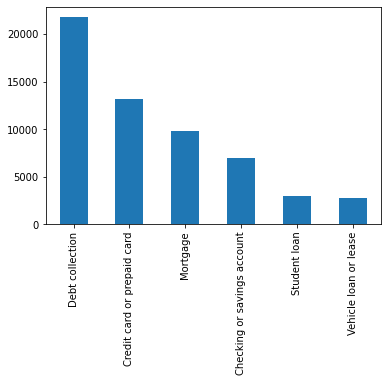

In [10]:
df['Product'].value_counts().plot(kind='bar')

In [11]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
Michael Haynes & Associates, LLC         1   
MEMBER FIRST MORTGAGE, LLC               1   
Local Management, LLC                    1   
Vander Financial, LLC                    1   
Capital Alliance Financial, LLC          1   
Name: Company, Length: 2197, dtype: int64

In [12]:
comp_df = df[['Consumer complaint narrative','Product','Company']].rename(columns = {'Consumer complaint narrative':'complaints'})

In [13]:
comp_df.head()

,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

Ordinal encoding of multiclass feature "product" into target

In [14]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(comp_df[['Product']])
comp_df['target'] = enc.transform(comp_df[['Product']])
comp_df['target']=comp_df['target'].astype(int)

In [15]:
comp_df.head()

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,2
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,0
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

Split dataset into train and test

In [16]:
x_train,x_test = train_test_split(comp_df,test_size = 0.2,random_state = 111)

Preprocessing and Tokenization,vectorization of consumer complaints feature.

In [17]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')

In [18]:
nltk.download('stopwords')
stop_words= set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and 
                                                          len(re.sub('\d+','',word.strip('Xx'))) > 3)]
  tokens = map(str.lower,tokens)
  stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [21]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(x_train.complaints)

In [22]:
vetorizer_tf = TfidfVectorizer(tokenizer=tokenize,stop_words=None, max_df = 0.75,max_features=1000,lowercase=False,
                               ngram_range=(1,2))
train_vectors = vetorizer_tf.fit_transform(x_train.complaints) 

In [23]:
test_vectors = vectorizer_tf.transform(x_test.complaints)

In [24]:
x_train.shape

(45962, 4)

Calculating class weigths of each class

In [25]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(x_train['target']),
                                             x_train['target']))
print('class_weights',class_weights)

class_weights [1.382232647660291, 0.7219918316054037, 0.43830939711239536, 0.9841127098321343, 3.275046316089497, 3.466214177978884]


In [26]:
weights = np.ones(x_train.shape[0], dtype = 'float')
print(weights)
for i, val in enumerate(x_train['target']):
  weights[i] = class_weights[val]

[1. 1. 1. ... 1. 1. 1.]


Training Xgboost model 

In [94]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [27]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6
                            , objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})
xgb_clf.fit(train_vectors,x_train['target'],sample_weight = weights)

[08:08:09] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [28]:
predictions = xgb_clf.predict(test_vectors)

In [29]:
print("Accuracy score (test): {0:.3f}".format(xgb_clf.score(test_vectors, x_test['target'])))

Accuracy score (test): 0.849


In [30]:
cm = confusion_matrix(x_test['target'], predictions)
print(cm)

[[1293   92   32   17    5   22]
 [ 172 2114  169   19    2  107]
 [ 109  187 3644   80   87  188]
 [  32   19   42 1779   55   88]
 [   3    6   27    4  514   57]
 [  12   19   52   10   21  412]]


In [31]:
print('classification_report :\n',classification_report(x_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.80      0.89      0.84      1461
           1       0.87      0.82      0.84      2583
           2       0.92      0.85      0.88      4295
           3       0.93      0.88      0.91      2015
           4       0.75      0.84      0.79       611
           5       0.47      0.78      0.59       526

    accuracy                           0.85     11491
   macro avg       0.79      0.84      0.81     11491
weighted avg       0.86      0.85      0.85     11491



Multiclass classification using ANN

>


In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import datetime

In [54]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df['Product']),
                                             df['Product']))
class_weights.sort()

In [55]:
nweights  ={}
for index, weight in enumerate(class_weights) :
  nweights[index]=weight
nweights

{0: 0.43980801028844385,
 1: 0.7258015614340938,
 2: 0.9771915501581794,
 3: 1.3673425674710837,
 4: 3.2459322033898306,
 5: 3.4998172514619883}

In [73]:
x_train,x_test = train_test_split(df,test_size = 0.2,random_state = 111)

In [75]:
dataset_train = tf.data.Dataset.from_tensor_slices((x_train['Consumer complaint narrative'].values, x_train['Product'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test['Consumer complaint narrative'].values, x_test['Product'].values))

In [76]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['Debt collection', 'Credit card or prepaid card', 'Mortgage', 'Checking or savings account', 'Student loan', 'Vehicle loan or lease']),
        values=tf.constant([0, 1, 2, 3, 4, 5]),
    ),
    default_value=tf.constant(-1),
    name="target_encoding"
)

@tf.function
def target(x):
  return table.lookup(x)

In [77]:
def show_batch(dataset, size=5):
  for batch, label in dataset.take(size):
      print(batch.numpy())
      print(target(label).numpy())

In [78]:
show_batch(dataset_test,6)

b'I have a business checking account at BB & T. On XX/XX/2019, I attempted to deposit a check into my account and I received a message stating that I was over my monthly mobile deposit limit. I was confused because it was the first of the month and I had not deposited any checks since the previous month. I called BB & T and they said that I couldnt deposit checks into business accounts via the mobile app even though I had done that before. \n\nI was instructed to open a personal account, into which I could deposit checks via the mobile app. I was told that if I opened the account online I would have immediate access, that I could link my personal and business accounts, and immediately be able to transfer money between them. \n\nOn XX/XX/XXXX, I opened my personal account online. Though I successfully opened online, I did not have online access as I had been promised. Because I was traveling in an area where there were no BB & T branches, I could not go into a branch until XX/XX/2019. I

In [79]:
def fetch(text, labels):
  return text, tf.one_hot(target(labels),6)

In [80]:
train_data_f=dataset_train.map(fetch)
test_data_f=dataset_test.map(fetch)

In [81]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b"The below complaint was submitted to the CFPB numerous times prior, the Wells Fargo rep, XXXX XXXX, replies with the same general form response stating numerous attempts at resolution have been made and exhausted which is a lie. He also attempts to state he can not comment due to past litigation which is also a lie, he reverts to this reply so as to avoid detailing any supposed attempt at resolution which he can not as there is none. Further, he should be aware of resolution which is to refund fees totaling {$610.00} and has not done so, no refund received to date. Please see complaint below. The below complaint was submitted prior, a duplicate form response received from XXXX XXXX with Wells Fargo, one of several. Based on this, my complaint was not addressed. Further, a reply in XXXX was never received as was mentioned. XXXX replied by stating numerous attempts at resolution have been made but has not detailed one, there was no contact fro

In [82]:
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b"The below complaint was submitted to the CFPB numerous times prior, the Wells Fargo rep, XXXX XXXX, replies with the same general form response stating numerous attempts at resolution have been made and exhausted which is a lie. He also attempts to state he can not comment due to past litigation which is also a lie, he reverts to this reply so as to avoid detailing any supposed attempt at resolution which he can not as there is none. Further, he should be aware of resolution which is to refund fees totaling {$610.00} and has not done so, no refund received to date. Please see complaint below. The below complaint was submitted prior, a duplicate form response received from XXXX XXXX with Wells Fargo, one of several. Based on this, my complaint was not addressed. Further, a reply in XXXX was never received as was mentioned. XXXX replied by stating numerous attempts at resolution have been made but has not detailed one, there was no 

Adding embedding layer over hub.keraslayer and training ANN model using transfer learning

In [83]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 1.92570090e+00,  1.04540564e-01,  1.63910031e-01,
        -1.11070231e-01, -5.49944043e-02,  7.91307315e-02,
         4.86127660e-02,  2.75555283e-01, -8.30120146e-02,
         1.80027023e-01,  1.44885316e-01, -1.59288287e-01,
        -1.94997236e-01, -4.00722414e-01, -1.37285963e-01,
         3.61927778e-01, -3.39035988e-01, -3.47756073e-02,
        -6.16503179e-01,  1.44515026e+00,  3.19949985e-01,
         3.94565135e-01, -3.26071948e-01,  2.14843497e-01,
        -3.63146365e-02, -4.13899511e-01,  1.67138502e-01,
        -5.15444636e-01, -1.83536708e-01,  3.90481912e-02,
         9.09547061e-02, -2.18187377e-01,  1.16193175e-01,
        -2.13140637e-01,  2.62742490e-01,  3.77820075e-01,
        -2.58993626e-01, -5.08686364e-01, -2.61283755e-01,
        -5.75724877e-02,  5.14812469e-02, -1.78749681e-01,
        -8.78547728e-02, -5.78522384e-01,  3.56190205e-01,
         3.41897160e-01, -3.03279817e-01, -3.03550176e-02,
      

In [84]:
model = tf.keras.Sequential()
model.add(hub_layer)
for units in [128, 128, 64 , 32]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

In [85]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [86]:
train_data_f=train_data_f.shuffle(70000).batch(512)
test_data_f=test_data_f.batch(512)

In [93]:
history = model.fit(train_data_f,
                    epochs=10,
                    validation_data=test_data_f,
                    verbose=1,
                    class_weight=nweights)

Epoch 1/10
90/90 [==============================] - 5s 59ms/step - loss: 1.1402 - accuracy: 0.8955 - val_loss: 1.1676 - val_accuracy: 0.8750
Epoch 2/10
90/90 [==============================] - 5s 58ms/step - loss: 1.1284 - accuracy: 0.9087 - val_loss: 1.1656 - val_accuracy: 0.8769
Epoch 3/10
90/90 [==============================] - 5s 58ms/step - loss: 1.1212 - accuracy: 0.9120 - val_loss: 1.1652 - val_accuracy: 0.8777
Epoch 4/10
90/90 [==============================] - 5s 58ms/step - loss: 1.1152 - accuracy: 0.9200 - val_loss: 1.1676 - val_accuracy: 0.8748
Epoch 5/10
90/90 [==============================] - 5s 58ms/step - loss: 1.1124 - accuracy: 0.9218 - val_loss: 1.1722 - val_accuracy: 0.8705
Epoch 6/10
90/90 [==============================] - 5s 58ms/step - loss: 1.1103 - accuracy: 0.9242 - val_loss: 1.1664 - val_accuracy: 0.8759
Epoch 7/10
90/90 [==============================] - 5s 60ms/step - loss: 1.1069 - accuracy: 0.9279 - val_loss: 1.1640 - val_accuracy: 0.8783
Epoch 8/10
90

In [88]:
tlen = len(list(dataset_test))

In [89]:
results = model.evaluate(dataset_test.map(fetch).batch(tlen), verbose=2)
print(results)

1/1 - 0s - loss: 1.1801 - accuracy: 0.8631
[1.1800822019577026, 0.8631102442741394]


In [90]:
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(45963)))

In [91]:
y_pred=model.predict(test_data)

In [95]:
print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      4295
           1       0.86      0.84      0.85      2583
           2       0.93      0.89      0.91      2015
           3       0.81      0.88      0.84      1461
           4       0.78      0.85      0.82       611
           5       0.49      0.87      0.62       526

    accuracy                           0.86     11491
   macro avg       0.80      0.87      0.83     11491
weighted avg       0.88      0.86      0.87     11491



In [96]:
confusion_matrix(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1))

array([[3688,  192,   72,   75,   78,  190],
       [  83, 2162,   17,  179,   21,  121],
       [  33,   17, 1803,   35,   32,   95],
       [  13,  113,   24, 1287,    5,   19],
       [  17,   10,    1,    6,  521,   56],
       [  19,   14,   13,   14,    9,  457]])